# Atividade Computacional 1

PPGEE0018: Processamento Digital de Sinais.

Aluno: Ricardo Augusto de Araújo Machado

## Parte 1 - Amostragem com frequência maior que Nyquist.

In [1]:
from scipy.signal import butter, lfilter
import numpy as np
import seaborn as sns
#Whitegrid
sns.set_theme(style="whitegrid")
sns.set_palette("viridis")

Definição do sinal base. Soma de duas senoides com frequências de 5 Hz e 2 Hz, respectivamente.

$x(t) = \sin({2 \cdot \pi \cdot 5 t)} + 2\sin({2 \cdot \pi \cdot 2 t}$)

Para simular um sinal contínuo no código, a variável t é definida com intervalo entre amostras de $\Delta T = \frac{1}{200\cdot 5}\ s$, ou seja, o equivalente a uma frequência de amostragem 200 vezes maior do que a banda do sinal $x(t)$.

In [2]:
A1 = 1
A2 = 2
freq1 = 5
freq2 = 2
delta_amostragem = 1/(200*freq1) # Intervalo entre amostras
t = np.arange(0, 4/freq1, delta_amostragem)
sinal = A1*np.sin(2*np.pi*freq1*t) + A2*np.sin(2*np.pi*freq2*t)

Plot do sinal $x(t)$ com a base de tempo correspondente.

[Text(0.5, 1.0, 'Sinal composto por duas senóides'),
 Text(0.5, 0, 'Tempo (s)'),
 Text(0, 0.5, 'Amplitude')]

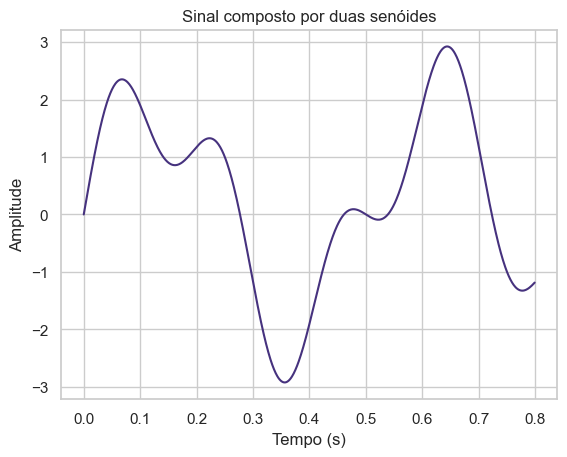

In [3]:
sns.lineplot(x=t, y=sinal).set(title='Sinal composto por duas senóides', xlabel='Tempo (s)', ylabel='Amplitude')

### Processo de discretização do sinal.

O sinal $x(t)$ é discretizado com frequência de amostragem maior que a taxa de Nyquist, ou seja, com frequência maior que duas vezes a banda do sinal.

Nesse exemplo, o sinal é amostrado com frequência de amostragem 5 vezes maior que a maior frequência do sinal $x(t)$, ou seja $f_s = 25\ \text{Hz}$.

In [4]:
freq_amostragem = 5*max(freq1, freq2)
t_discreto = np.arange(0, 4/freq1, 1/freq_amostragem)
sinal_discreto = A1*np.sin(2*np.pi*freq1*t_discreto) + A2*np.sin(2*np.pi*freq2*t_discreto)
k = np.arange(0, len(t_discreto))

In [5]:
freq_amostragem

25

O sinal em tempo discreto $x[n]$ é exibido no gráfico abaixo.

[Text(0.5, 1.0, 'Sinal discretizado'),
 Text(0.5, 0, 'Número da amostra'),
 Text(0, 0.5, 'Amplitude')]

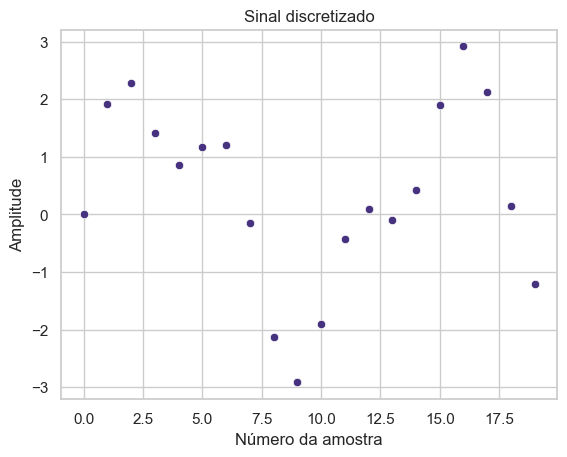

In [6]:
sns.scatterplot(x=k, y=sinal_discreto).set(title='Sinal discretizado', xlabel='Número da amostra', ylabel='Amplitude')

Comparação entre sinal discretizado $x[n]$ e sinal em tempo contínuo.

<Axes: title={'center': 'Sinal composto por duas senóides'}, xlabel='Tempo (s)', ylabel='Amplitude'>

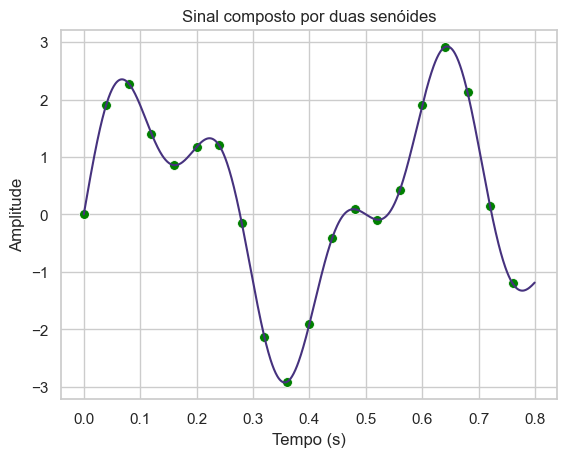

In [7]:
sns.lineplot(x=t, y=sinal).set(title='Sinal composto por duas senóides', xlabel='Tempo (s)', ylabel='Amplitude')
sns.scatterplot(x=t_discreto, y=sinal_discreto, color='green',s=50)

## Processo de quantização do sinal.

Para uma quantização com $N$ bits tem-se que o intervalo de quantização é: $\Delta = \frac{2X_m}{2^N}$, com $X_m$ representando o fundo de escala do processo de quantização.

Em seguida, o sinal quantizado $\hat{x}[n]$ é obtido fazendo:

$$ \hat{x}[n] = \text{arredondar}\left(\frac{x[n]}{\Delta}\right)\times \Delta$$

In [8]:
def quantizar_sinal(sinal: np.ndarray, bits: int) -> np.ndarray:
    niveis_logicos = 2**bits
    fundo_escala = max(abs(min(sinal)), abs(max(sinal)))
    delta_quantizacao = 2*fundo_escala/niveis_logicos
    sinal_quantizado = np.round(sinal/delta_quantizacao)*delta_quantizacao
    return sinal_quantizado

In [9]:
sinal_quantizado_10bits = quantizar_sinal(sinal_discreto, 10)

O sinal quantizado é visto na figura abaixo.

[Text(0.5, 1.0, 'Sinal quantizado'),
 Text(0.5, 0, 'Número da amostra'),
 Text(0, 0.5, 'Amplitude')]

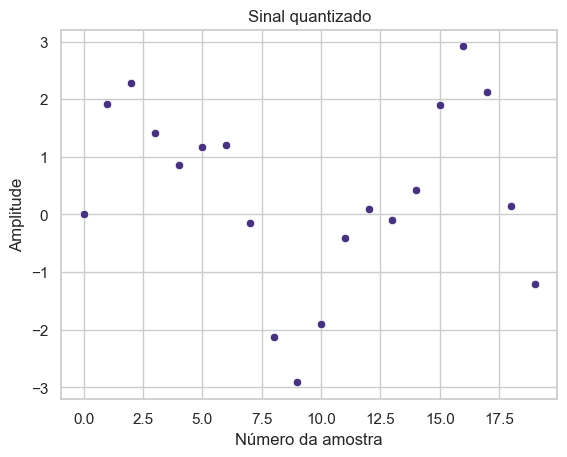

In [10]:
sns.scatterplot(x=k, y=sinal_quantizado_10bits).set(title='Sinal quantizado', xlabel='Número da amostra', ylabel='Amplitude')

O sinal de erro da quantização definido por: $e[n] = \hat{x}[n] - x[n]$ é visualizado abaixo. O maior erro obtido foi de 0.0025.

In [11]:
print(f"Erro máximo de quantização (10 bits): {max(abs(sinal_discreto - sinal_quantizado_10bits)):.4f}")

Erro máximo de quantização (10 bits): 0.0025


[Text(0.5, 1.0, 'Erro de quantização (10 bits)'),
 Text(0.5, 0, 'Número da amostra'),
 Text(0, 0.5, 'Amplitude')]

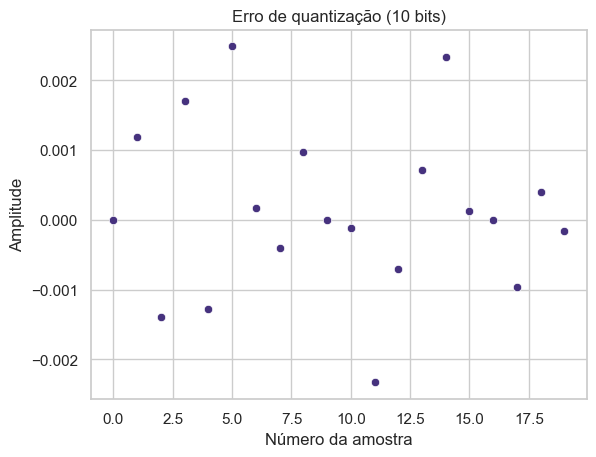

In [12]:
erro_quantizacao_10bits = sinal_discreto - sinal_quantizado_10bits
sns.scatterplot(x=k, y=erro_quantizacao_10bits).set(title='Erro de quantização (10 bits)', xlabel='Número da amostra', ylabel='Amplitude')

Comparação entre sinal de tempo contínuo e sinal quantizado.

<Axes: title={'center': 'Sinal composto por duas senóides'}, xlabel='Tempo (s)', ylabel='Amplitude'>

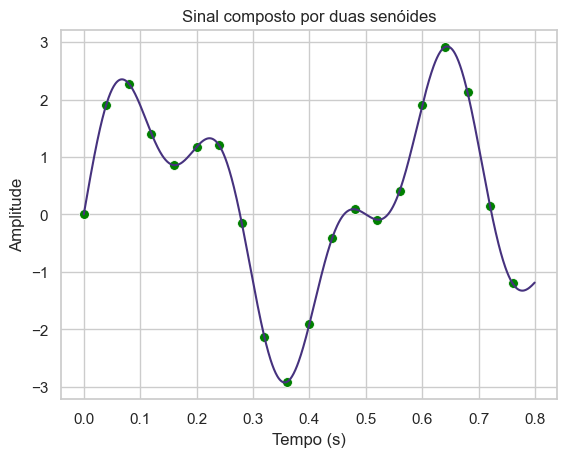

In [13]:
sns.lineplot(x=t, y=sinal).set(title='Sinal composto por duas senóides', xlabel='Tempo (s)', ylabel='Amplitude')
sns.scatterplot(x=t_discreto, y=sinal_quantizado_10bits, color='green',s=50)

## Recuperação do sinal por interpolação linear + filtragem.

A recuperação do sinal é realizada por meio de interpolação linear no sinal quantizado junto com um filtro Butterworth passa-baixa de ordem 12 com frequência de corte de 5 Hz.

In [14]:
def recuperar_sinal(sinal_amostrado: np.ndarray, t_amostragem: np.ndarray, t_continuo: np.ndarray) -> np.ndarray:
    sinal_recuperado = np.interp(t_continuo, t_amostragem, sinal_amostrado)
    freq_corte = 5
    b, a = butter(12, freq_corte, btype='low', analog=False, fs=freq_amostragem)
    sinal_filtrado = lfilter(b, a, sinal_recuperado)
    return sinal_filtrado


<Axes: title={'center': 'Sinal composto por duas senóides'}, xlabel='Tempo (s)', ylabel='Amplitude'>

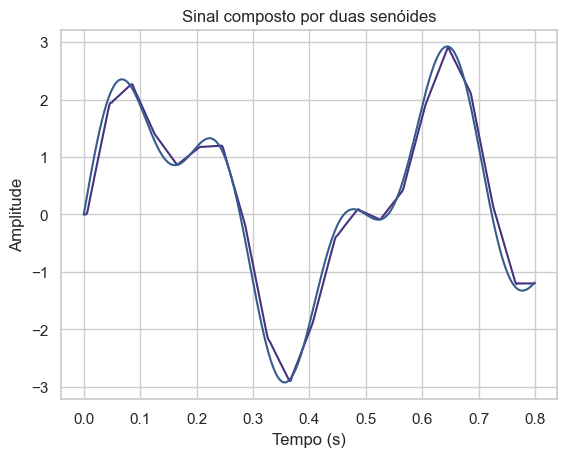

In [15]:
sinal_recuperado = recuperar_sinal(sinal_quantizado_10bits, t_discreto, t)
sns.lineplot(x=t, y=sinal_recuperado).set(title='Sinal composto por duas senóides', xlabel='Tempo (s)', ylabel='Amplitude')
sns.lineplot(x=t, y=sinal)

# Parte 2 - Quantização com 2 bits.